# 10/15/24: encoding phase plots
* As a reminder, 16 subjs across 29 session undergo watched an ~8 min film.
 
After wrangling all their data into 1 df, I plotted:  
1. Distribution of RTs
2. Rasters & PSTHs for example cells from each region. For the latter, I trimmed all trials to 5s.  
3. Distribution of avg FRs across trials (non-zero FRs only)
4. Trial-avged FR for correct vs incorrect (note that these are imbalanced classes as printed above the plot)
5. Trial-avged FR for (correct+high confidence) vs others (much better balanced)


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

### confirm number of subjects, neurons, trials

In [2]:
df = pd.read_pickle('neuron_by_trial_df.pkl')
df_encoding = df[df['stim_phase'] == 'encoding']
df_encoding = df_encoding[df_encoding['FR'] != 0] # 1 session with 7 neurons recorded gets dropped

num_subjs = len(np.unique(df_encoding['subj']))
num_sessions = len(np.unique(df_encoding['sess']))
num_neurons = len(np.unique(df_encoding['neuron']))
print(f'{num_subjs} subjects, {num_sessions} sessions, {num_neurons} neurons')
print(f'number of rows = number of neurons = {len(df_encoding)}')

df_encoding.head()

16 subjects, 29 sessions, 1450 neurons
number of rows = number of neurons = 1450


,subj,sess,neuron,region,start_time,stop_time,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes,trial_smooth_FR,stim_phase,stimulus_file,response_correct,response_confidence,actual_response
0,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,0.0,478.85512,478.85512,"[3.43207675, 4.39507675, 5.16801325, 5.2624507...","[3.43207675, 4.39507675, 5.16801325, 5.2624507...",360,0.751793,"[10, 12, 5, 5, 8, 7, 6, 7, 6, 2, 2, 2, 1, 5, 5...",7.557895,encoding,bd_movie,NaN,NaN,NaN
41,P41,P41CS_R1,P41CS_R1_38_1_613_5,ACC,0.0,478.85512,478.85512,"[0.2510465, 2.07970175, 4.70126325, 5.09220075...","[0.2510465, 2.07970175, 4.70126325, 5.09220075...",278,0.580551,"[5, 5, 3, 2, 3, 7, 10, 6, 7, 13, 9, 2, 4, 7, 7...",5.800000,encoding,bd_movie,NaN,NaN,NaN
82,P41,P41CS_R1,P41CS_R1_39_1_1359_5,ACC,0.0,478.85512,478.85512,"[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...","[0.3880465, 1.5347965, 1.61257775, 2.0414215, ...",949,1.981810,"[9, 15, 18, 17, 17, 12, 10, 20, 34, 31, 18, 10...",19.831579,encoding,bd_movie,NaN,NaN,NaN
123,P41,P41CS_R1,P41CS_R1_40_1_2816_5,ACC,0.0,478.85512,478.85512,"[0.0642965, 0.80051525, 0.813359, 0.89145275, ...","[0.0642965, 0.80051525, 0.813359, 0.89145275, ...",1820,3.800732,"[29, 24, 34, 43, 32, 39, 43, 40, 33, 31, 43, 4...",38.084211,encoding,bd_movie,NaN,NaN,NaN
164,P41,P41CS_R1,P41CS_R1_40_2_2821_5,ACC,0.0,478.85512,478.85512,"[0.4351715, 0.88882775, 1.79107775, 3.7156705,...","[0.4351715, 0.88882775, 1.79107775, 3.7156705,...",379,0.791471,"[11, 10, 8, 8, 8, 8, 4, 9, 11, 9, 13, 8, 3, 4,...",7.936842,encoding,bd_movie,NaN,NaN,NaN


In [54]:
print(len(df_encoding['trial_smooth_spikes'].unique()))


TypeError: unhashable type: 'numpy.ndarray'

In [40]:
scene_cuts_df = pd.read_csv('../assets/annotations/scenecut_info.csv')
scene_cuts_ts = scene_cuts_df['shot_start_t'].tolist()
scene_cuts_df.head()

,scene_id,shot_start_fr,shot_start_t,shot_dur_t,location,cut_type,cut_dur_t,cut_dur_fr
0,1.0,1.0,0.00,4.72,backyard,cut,0.0,0
1,1.0,119.0,4.72,10.28,backyard,cut,0.0,0
2,1.0,376.0,15.00,1.72,backyard,cut,0.0,0
3,1.0,419.0,16.72,2.36,backyard,cut,0.0,0
4,1.0,478.0,19.08,2.64,backyard,cut,0.0,0


In [ ]:
df_encoding.head

1450 trials


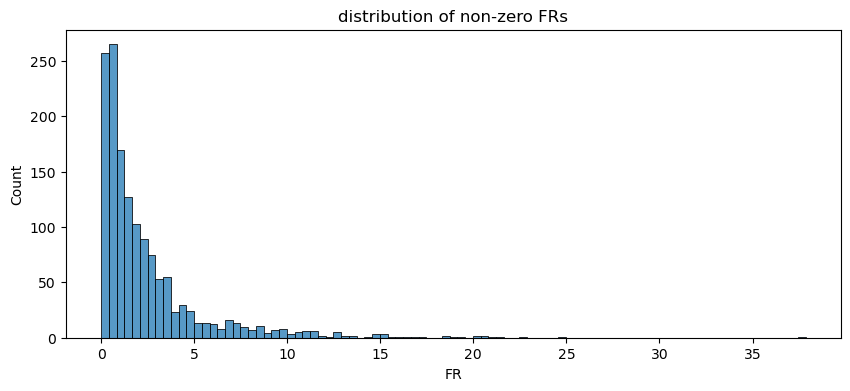

In [ ]:
print(f'{len(df_encoding)} trials')

plt.figure(figsize=(10,4))
sns.histplot(df_encoding['FR'])
plt.title('distribution of non-zero FRs')
plt.show()

### smooth FRs of individual neurons from different regions, across sessions

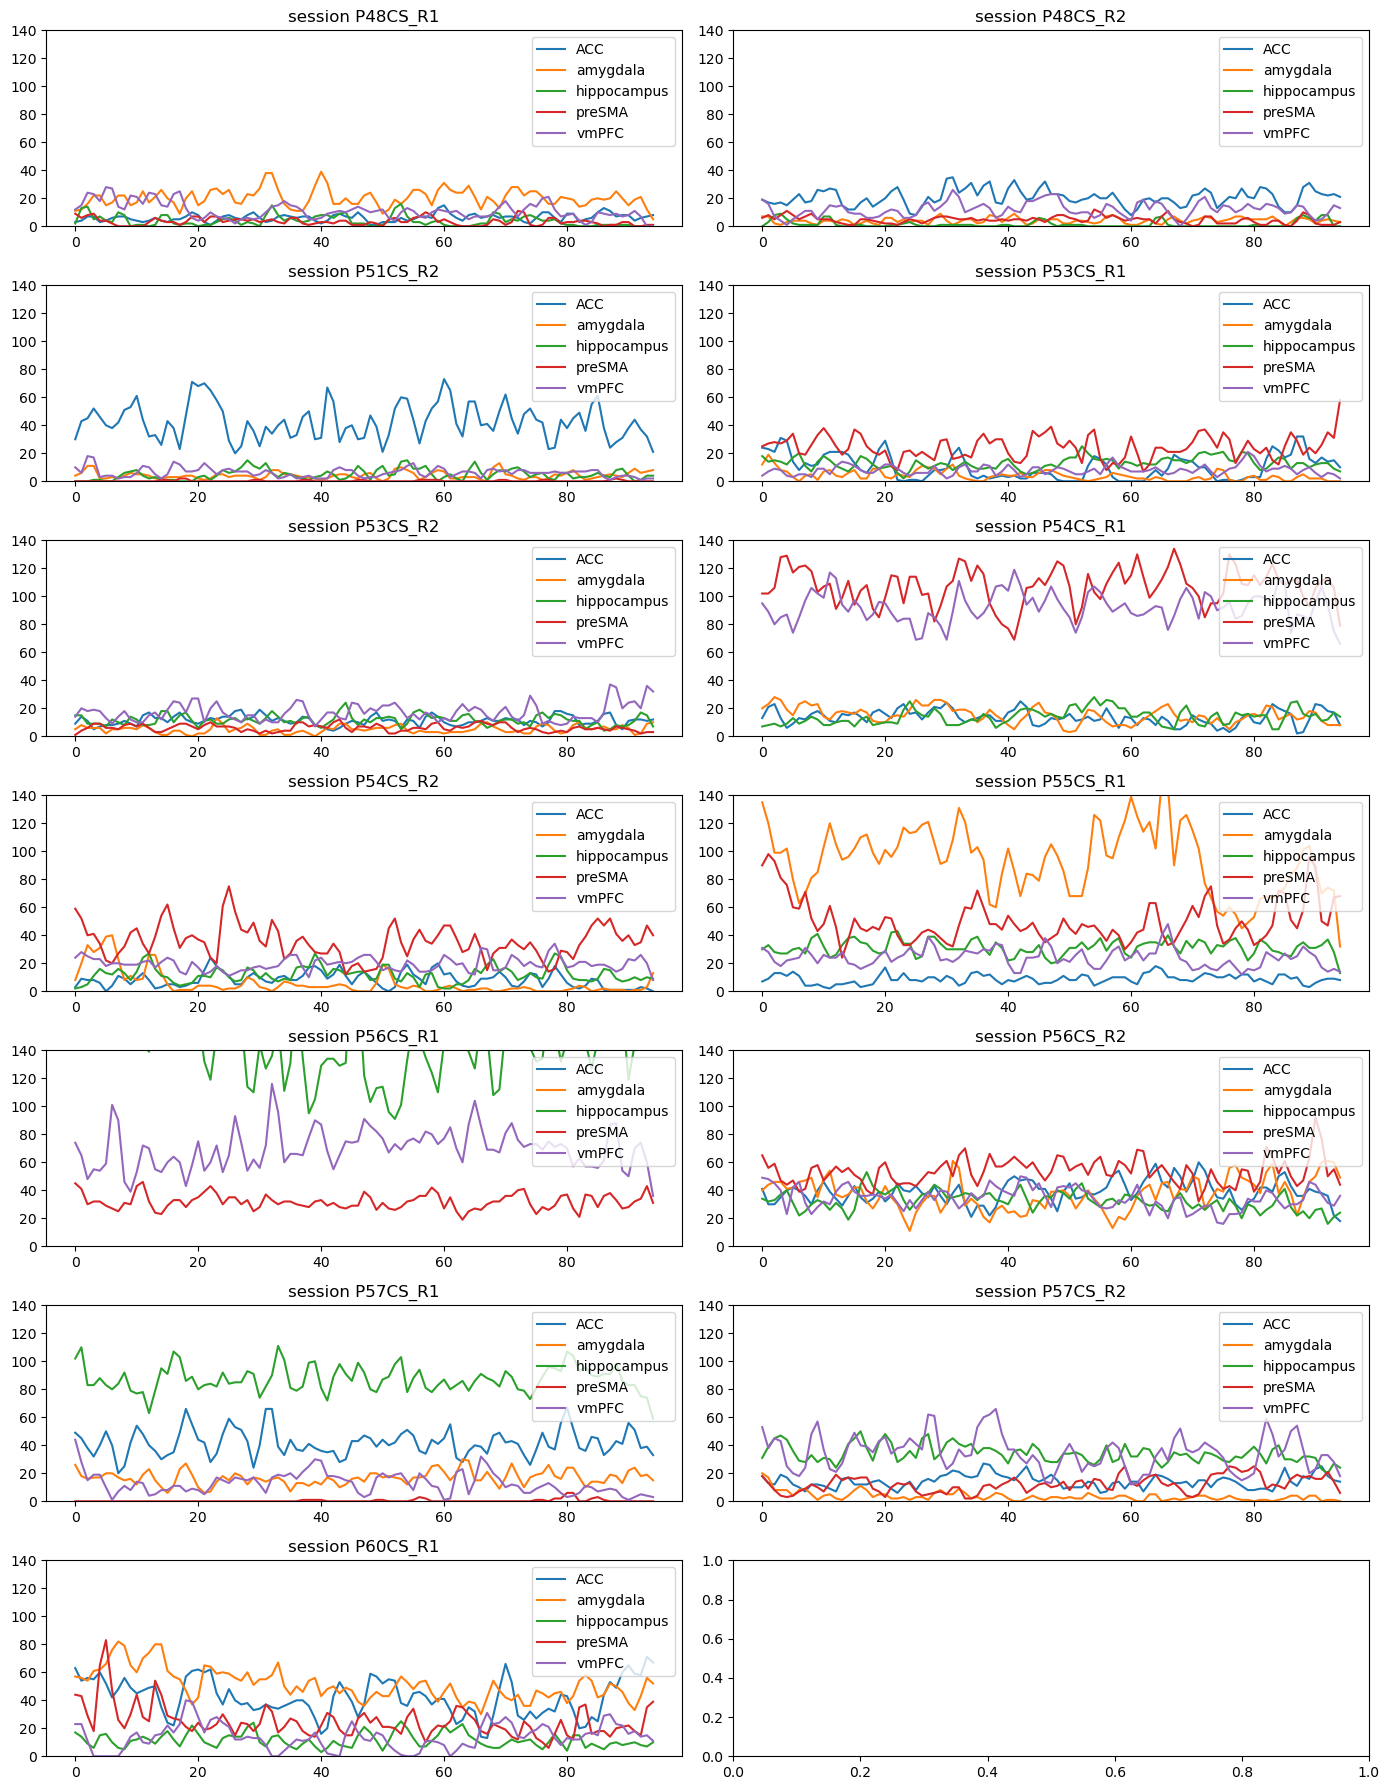

In [45]:
sess_num = 0  # specify how many sessions to plot

fig, axs = plt.subplots(7, 2, figsize=(14, 18)) # only 13 sessions have recordings from all 5 regions
axs = axs.flatten()

for session, session_df in df_encoding.groupby('sess'):

    # if this session does not have recordings from all 5 regions, continue to next session
    if not len(np.unique(session_df['region'])) == 5:
        continue

    for region, region_df in session_df.groupby('region'):

        neuron_groups = list(region_df.groupby('neuron'))

        # pick random neuron from each region
        rand_neuron_id = np.random.randint(len(neuron_groups))
        neuron, neuron_df = neuron_groups[rand_neuron_id]
        
        axs[sess_num].plot(neuron_df['trial_smooth_spikes'].tolist()[0], label=region)

    # Make vertical lines at each point in scene_cuts_ts
    # for cut in scene_cuts_ts:
    #     axs[sess_num].axvline(x=cut, color='r', linestyle='--')  # Customize color and style as needed

    axs[sess_num].set_title(f'session {session}')
    axs[sess_num].set_ylim(0, 140)
    axs[sess_num].legend(loc='upper right')
    
    sess_num += 1
    if sess_num > 13:  # only 13 sessions have recordings from all 5 regions
        break

plt.tight_layout()  
plt.show()


475.44


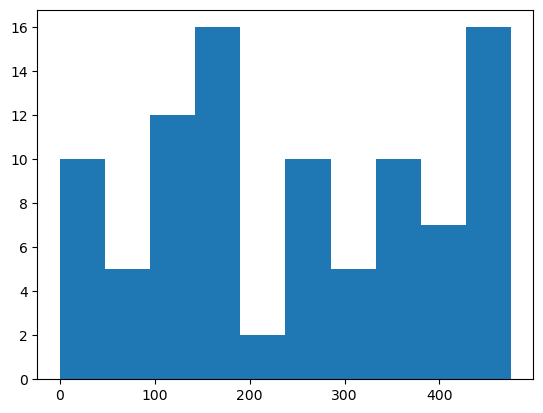

In [44]:
print(max(scene_cuts_ts))
plt.hist(scene_cuts_ts)
plt.show()

In [ ]:
sess_num = 0  # specify how many sessions to plot

fig, axs = plt.subplots(7, 2, figsize=(14, 18)) # only 13 sessions have recordings from all 5 regions
axs = axs.flatten()

for session, session_df in df_encoding.groupby('sess'):

    # if this session does not have recordings from all 5 regions, continue to next session
    if not len(np.unique(session_df['region'])) == 5:
        continue

    for region, region_df in session_df.groupby('region'):

        neuron_groups = list(region_df.groupby('neuron'))

        # pick random neuron from each region
        rand_neuron_id = np.random.randint(len(neuron_groups))
        neuron, neuron_df = neuron_groups[rand_neuron_id]
        
        axs[sess_num].plot(neuron_df['trial_smooth_spikes'].tolist()[0], label=region)

    axs[sess_num].set_title(f'session {session}')
    axs[sess_num].set_ylim(0, 140)
    axs[sess_num].legend(loc='upper right')
    
    sess_num += 1
    if sess_num > 13:  # only 13 sessions have recordings from all 5 regions
        break

plt.tight_layout()  
plt.show()


### trial-avged FRs by correctness

In [30]:
# print(df_recognition.groupby(['region', 'response_correct']).size())

# trial_avg_fr = df_recognition.groupby(['region', 'neuron', 'response_correct'])['FR'].mean().reset_index()
# plt.figure(figsize=(12, 6))
# sns.violinplot(data=trial_avg_fr, x='region', y='FR', hue='response_correct')
# plt.title('Trial-avged neuron FR')
# plt.show()
